In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import pydicom

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
373,00001977_000.png,No Finding,0,1977,067Y,M,PA,2500,2048,0.171,0.171
688,00003534_027.png,No Finding,27,3534,022Y,F,AP,2812,2544,0.139,0.139
1037,00005418_009.png,No Finding,9,5418,063Y,M,PA,2500,2048,0.168,0.168
3356,00016574_001.png,Effusion,1,16574,064Y,M,PA,2992,2991,0.143,0.143
184,00001047_003.png,No Finding,3,1047,078Y,F,PA,2598,2991,0.143,0.143


In [3]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
110759,00030183_000.png,Nodule,0,30183,48,F,PA,2021,2021,0.194311,0.194311,NaN
23401,00006203_000.png,No Finding,0,6203,42,M,PA,2500,2048,0.168000,0.168000,NaN
39830,00010406_005.png,No Finding,5,10406,17,M,AP,2500,2048,0.168000,0.168000,NaN


In [4]:
## EDA
# Todo 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print(all_labels)

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
6861,00001836_047.png,Atelectasis|Infiltration|Nodule,47,1836,49,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
65088,00016065_002.png,Atelectasis,2,16065,36,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55075,00013787_002.png,No Finding,2,13787,50,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
## Check for null values

all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  Atelectasis                  112120 non-null  float64
 13 

In [6]:
all_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [7]:
len(all_labels)

15

# Explore Demographics

Text(0.5, 1.0, 'Patient Gender Distribution')

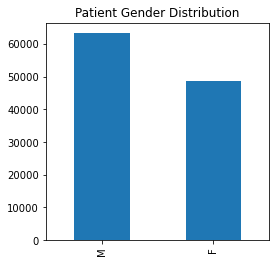

In [8]:
plt.figure(figsize=(4,4))
all_xray_df["Patient Gender"].value_counts().plot(kind = "bar")
plt.title('Patient Gender Distribution')

(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

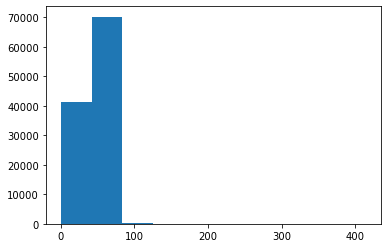

In [33]:
plt.hist(all_xray_df["Patient Age"].to_list())

Text(0.5, 1.0, 'Patient Age Distribution')

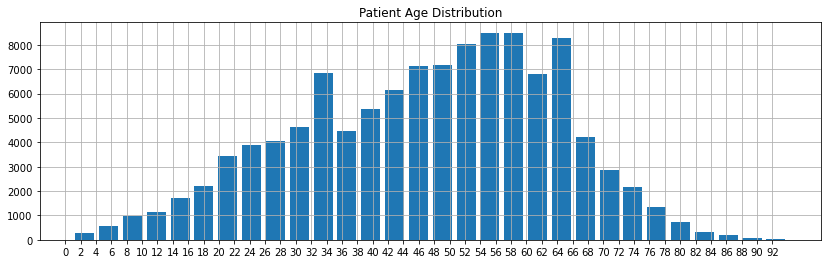

In [39]:
df = all_xray_df[all_xray_df["Patient Age"]<95]
plt.figure(figsize=(14,4))
df["Patient Age"].hist(rwidth=0.8, bins=30)
plt.xticks(range(0, np.max(df['Patient Age']), 2))
plt.title('Patient Age Distribution')

Text(0.5, 1.0, 'View Position Distribution')

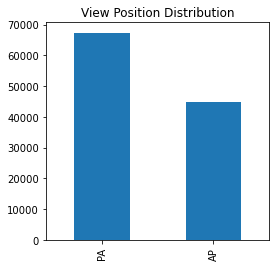

In [11]:
plt.figure(figsize=(4,4))
all_xray_df["View Position"].value_counts().plot(kind = "bar")
plt.title('View Position Distribution')

Text(0.5, 1.0, 'Follow-up # Distribution')

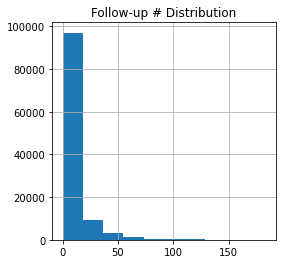

In [12]:
plt.figure(figsize=(4,4))
all_xray_df["Follow-up #"].hist()
plt.title("Follow-up # Distribution")

# The distribution of other diseases that are comorbid with pneumonia

[Text(0, 0.5, 'Number of Images with Label')]

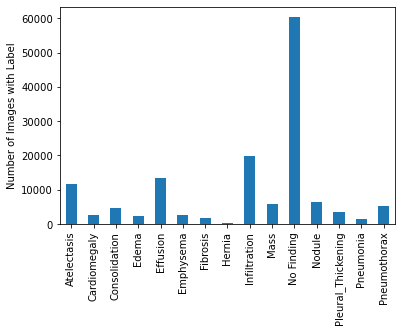

In [13]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [14]:
# Number of patients for each diseases
all_xray_df[all_labels].sum()

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

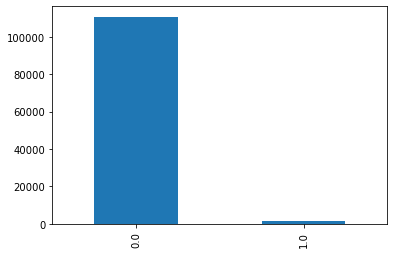

In [15]:
all_xray_df["Pneumonia"].value_counts().plot(kind='bar')

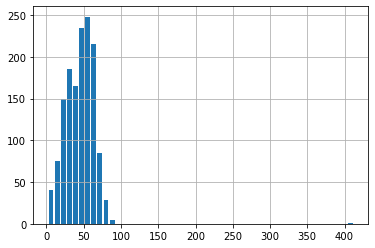

In [16]:
all_xray_df[all_xray_df.Pneumonia ==1]["Patient Age"].hist(rwidth=0.8, bins=50)

In [21]:
all_xray_df[all_xray_df.Pneumonia ==1]["Patient Age"].describe()

count    1431.000000
mean       44.927324
std        20.129866
min         2.000000
25%        31.000000
50%        46.000000
75%        59.000000
max       412.000000
Name: Patient Age, dtype: float64

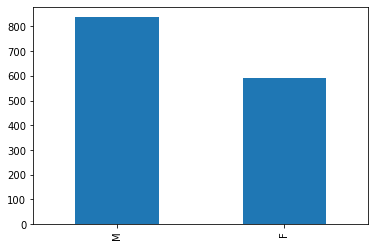

In [20]:
all_xray_df[all_xray_df.Pneumonia ==1]["Patient Gender"].value_counts().plot(kind ="bar")

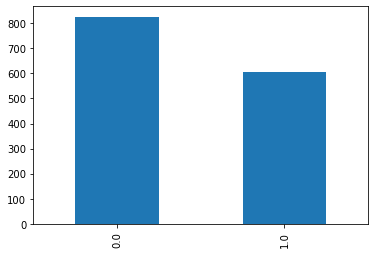

In [21]:
all_xray_df[all_xray_df.Pneumonia ==1]["Infiltration"].value_counts().plot(kind ="bar")

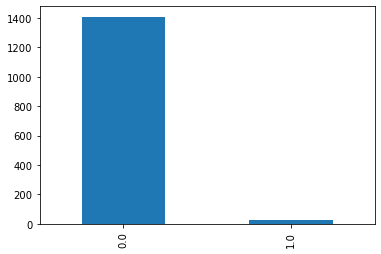

In [22]:
all_xray_df[all_xray_df.Pneumonia ==1]["Emphysema"].value_counts().plot(kind ="bar")

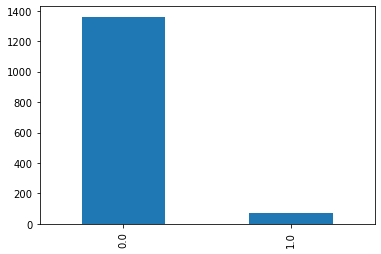

In [23]:
all_xray_df[all_xray_df.Pneumonia ==1]["Nodule"].value_counts().plot(kind ="bar")

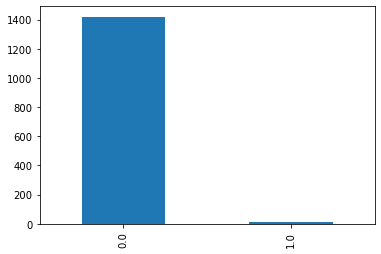

In [24]:
all_xray_df[all_xray_df.Pneumonia ==1]["Fibrosis"].value_counts().plot(kind ="bar")

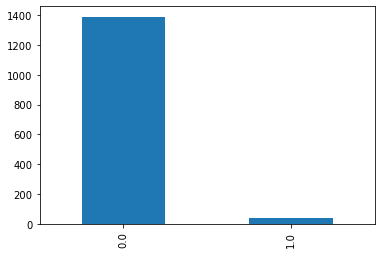

In [25]:
all_xray_df[all_xray_df.Pneumonia ==1]["Pneumothorax"].value_counts().plot(kind ="bar")


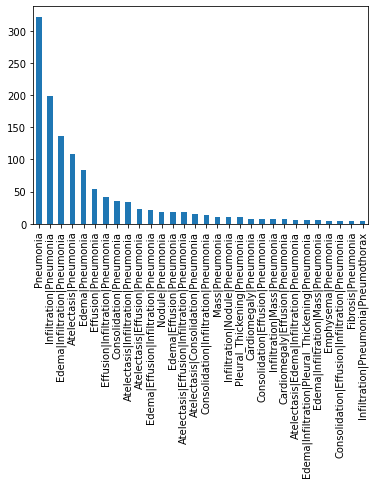

In [26]:
all_xray_df[all_xray_df['Pneumonia'] == 1]['Finding Labels'].value_counts()[:30].plot(kind='bar')

# Number of disease per patient

In [27]:
# Number of disease per patient
all_xray_df["Number_disease"] = all_xray_df.apply(lambda x: sum(x[all_labels])  , axis=1)


In [28]:
all_xray_df["Number_disease"].value_counts()

1.0    91324
2.0    14306
3.0     4856
4.0     1247
5.0      301
6.0       67
7.0       16
9.0        2
8.0        1
Name: Number_disease, dtype: int64

Text(0, 0.5, 'Patients Count')

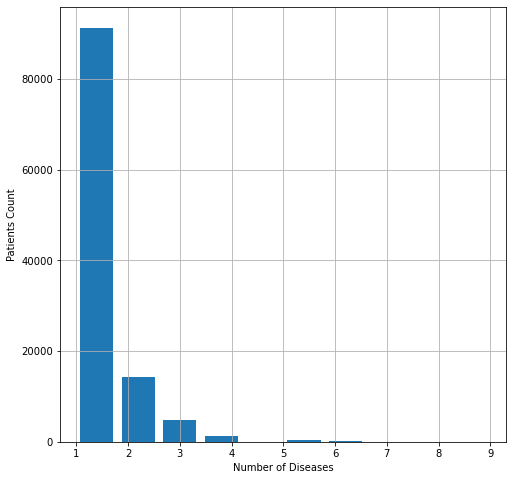

In [29]:
plt.figure(figsize=(8,8))
all_xray_df["Number_disease"].hist(rwidth=0.8)
plt.xlabel('Number of Diseases')
plt.ylabel('Patients Count')

# Pixel-level assessments of the Imaging Data

In [30]:
## Let's examine one DICOM file and its contents 
dcm = pydicom.dcmread('test1.dcm')
dcm

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

In [31]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 5606


In [107]:
sample_df[sample_df["No Finding"]==1][["path", "View Position" ]]

,path,View Position
2,/data/images_001/images/00000017_001.png,AP
6,/data/images_001/images/00000042_002.png,AP
7,/data/images_001/images/00000057_001.png,AP
9,/data/images_001/images/00000061_019.png,AP
12,/data/images_001/images/00000080_005.png,PA
...,...,...
5597,/data/images_012/images/00030639_001.png,AP
5600,/data/images_012/images/00030704_000.png,PA
5601,/data/images_012/images/00030712_000.png,PA
5604,/data/images_012/images/00030792_000.png,PA


In [108]:
sample_df[sample_df["No Finding"]==0][["path", "View Position" ]]

,path,View Position
0,/data/images_001/images/00000013_005.png,AP
1,/data/images_001/images/00000013_026.png,AP
3,/data/images_001/images/00000030_001.png,PA
4,/data/images_001/images/00000032_001.png,AP
5,/data/images_001/images/00000040_003.png,PA
...,...,...
5595,/data/images_012/images/00030636_014.png,PA
5598,/data/images_012/images/00030650_002.png,PA
5599,/data/images_012/images/00030695_002.png,PA
5602,/data/images_012/images/00030786_005.png,AP


In [33]:

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [94]:
def normalized_img(img):
    data = img.ravel()
    normalized = (data-np.mean(data))/(np.std(data))
    return normalized


Text(0.5, 1.0, 'Finding with AP Position')

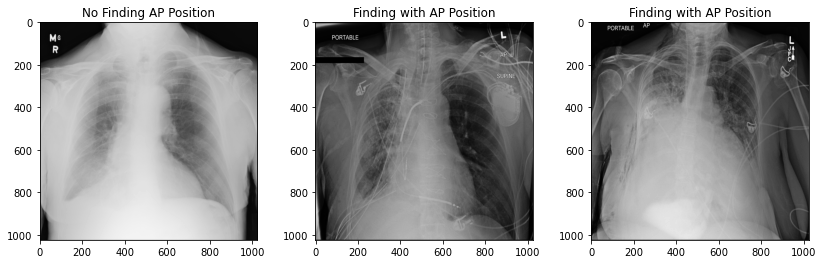

In [98]:
sampimg1= plt.imread('/data/images_001/images/00000017_001.png')
sampimg2= plt.imread('/data/images_001/images/00000013_005.png')
sampimg3= plt.imread('/data/images_012/images/00030786_005.png')


plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.imshow(sampimg1, cmap='gray')
plt.title('No Finding AP Position')

plt.subplot(1, 3, 2)
plt.imshow(sampimg2, cmap='gray')
plt.title('Finding with AP Position')

plt.subplot(1, 3, 3)
plt.imshow(sampimg3, cmap='gray')
plt.title('Finding with AP Position')

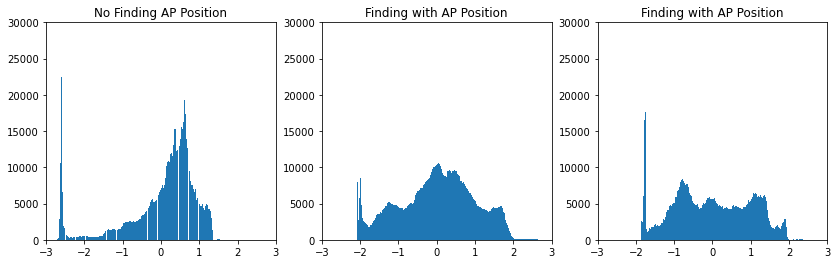

In [123]:
sampimg1_n = normalized_img(sampimg1)
sampimg2_n = normalized_img(sampimg2)
sampimg3_n = normalized_img(sampimg3)

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.hist(sampimg1_n,bins=256)
plt.xlim(xmin=-3,xmax=3)
plt.ylim(ymin= 0,ymax=30000)
plt.title("No Finding AP Position")

plt.subplot(1, 3, 2)
plt.hist(sampimg2_n.ravel(),bins=256)
plt.xlim(xmin=-3,xmax=3)
plt.ylim(ymin= 0,ymax=30000)
plt.title("Finding with AP Position")

plt.subplot(1, 3, 3)
plt.hist(sampimg3_n.ravel(),bins=256)
plt.xlim(xmin=-3,xmax=3)
plt.ylim(ymin= 0,ymax=30000)
plt.title("Finding with AP Position")

plt.show()

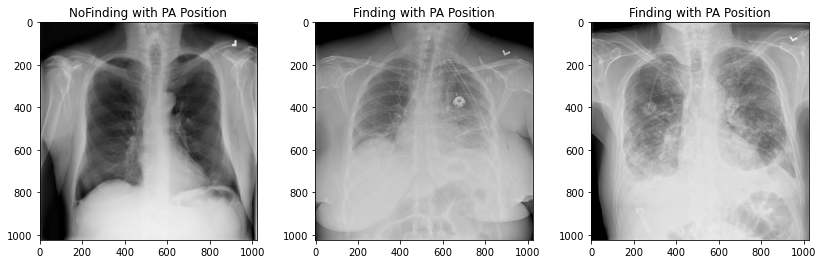

In [129]:
sampimg4= plt.imread('/data/images_001/images/00000030_001.png')
sampimg5= plt.imread('/data/images_012/images/00030695_002.png')
sampimg6= plt.imread('/data/images_012/images/00030650_002.png')
# /data/images_012/images/00030650_002.png
# /data/images_012/images/00030695_002.png

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)

plt.imshow(sampimg4, cmap='gray')
plt.title('NoFinding with PA Position')

plt.subplot(1, 3, 2)

plt.imshow(sampimg5, cmap='gray')
plt.title('Finding with PA Position')

plt.subplot(1, 3, 3)
plt.imshow(sampimg6, cmap='gray')
plt.title('Finding with PA Position')
plt.show()

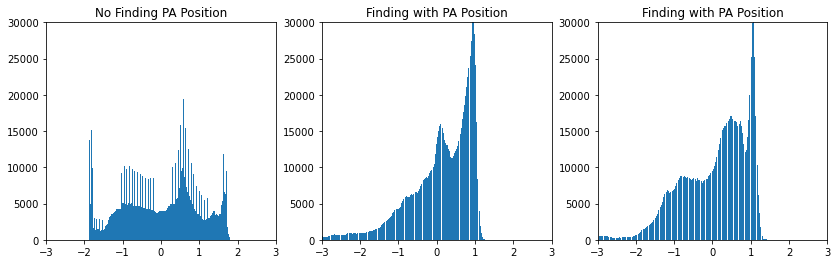

In [130]:
sampimg4_n = normalized_img(sampimg4)
sampimg5_n = normalized_img(sampimg5)
sampimg6_n = normalized_img(sampimg6)

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.hist(sampimg4_n,bins=200)
plt.xlim(xmin=-3,xmax=3)
plt.ylim(ymin= 0,ymax=30000)
plt.title("No Finding PA Position")

plt.subplot(1, 3, 2)
plt.hist(sampimg5_n,bins=200)
plt.xlim(xmin=-3,xmax=3)
plt.ylim(ymin= 0,ymax=30000)
plt.title("Finding with PA Position")

plt.subplot(1, 3, 3)
plt.hist(sampimg6_n,bins=200)
plt.xlim(xmin=-3,xmax=3)
plt.ylim(ymin= 0,ymax=30000)
plt.title("Finding with PA Position")

plt.show()